# Dust extinction models in Rubix

This notebook shows the basics of the dust extinction models implemented in Rubix. We have closely followed the implementation by the [dust extinction package](https://dust-extinction.readthedocs.io/en/latest/index.html). Currently we only support a subset of all available models.

In [1]:
# NBVAL_SKIP
from rubix.spectra.dust.extinction_models import Cardelli89, Gordon23

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

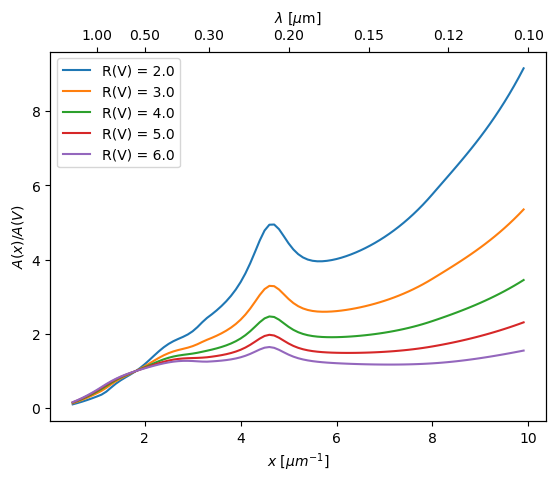

In [3]:
# NBVAL_SKIP
fig, ax = plt.subplots()

# generate the curves and plot them
x = np.arange(0.5,10.0,0.1) # in 1/microns
Rvs = [2.0,3.0,4.0,5.0,6.0]
for cur_Rv in Rvs:
    ext_model = Cardelli89(Rv=cur_Rv)
    ax.plot(x,ext_model(x),label='R(V) = ' + str(cur_Rv))

ax.set_xlabel(r'$x$ [$\mu m^{-1}$]')
ax.set_ylabel(r'$A(x)/A(V)$')

# for 2nd x-axis with lambda values
axis_xs = np.array([0.1, 0.12, 0.15, 0.2, 0.3, 0.5, 1.0])
new_ticks = 1 / axis_xs
new_ticks_labels = ["%.2f" % z for z in axis_xs]
tax = ax.twiny()
tax.set_xlim(ax.get_xlim())
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_ticks_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")

ax.legend(loc='best')

In [4]:
# initialize cardelli model with Rv=3.1
ext = Cardelli89(Rv=3.1)

In [5]:
# generate wavelengths between 3 and 10 microns
#    within the valid range for the Cardelli R(V) dependent model
lam = np.logspace(np.log10(3), np.log10(10.0), num=1000)

In [6]:
# setup the inputs for the blackbody function
wavelengths = lam*1e4 # Angstroem
temperature = 10000 # Kelvin

In [7]:
from astropy.modeling.models import BlackBody
import astropy.units as u

In [8]:
# get the blackbody flux
bb_lam = BlackBody(10000*u.K, scale=1.0 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
flux = bb_lam(wavelengths)

In [9]:
# get the extinguished blackbody flux for different amounts of dust
flux_ext_av05 = flux*ext.extinguish(lam, Av=0.5)
flux_ext_av15 = flux*ext.extinguish(lam, Av=1.5)
flux_ext_ebv10 = flux*ext.extinguish(lam, Ebv=1.0)

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
/var/folders/c2/61w7yp_x4yd0_21snh453rmm0000gq/T/ipykernel_79163/3016050321.py:10: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$ [$\AA$]')


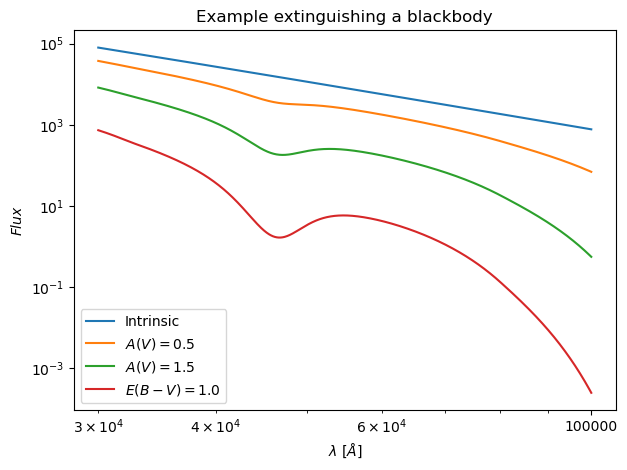

In [10]:
# plot the intrinsic and extinguished fluxes
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots()

ax.plot(wavelengths, flux, label='Intrinsic')
ax.plot(wavelengths, flux_ext_av05, label='$A(V) = 0.5$')
ax.plot(wavelengths, flux_ext_av15, label='$A(V) = 1.5$')
ax.plot(wavelengths, flux_ext_ebv10, label='$E(B-V) = 1.0$')

ax.set_xlabel('$\lambda$ [$\AA$]')
ax.set_ylabel('$Flux$')

ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_yscale('log')

ax.set_title('Example extinguishing a blackbody')

ax.legend(loc='best')
plt.tight_layout()

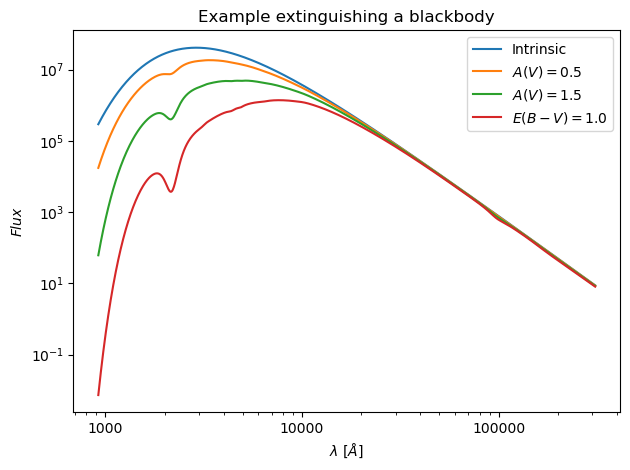

In [11]:
# generate wavelengths between 0.092 and 31 microns
#    within the valid range for the Gordon23 R(V) dependent relationship
lam = jnp.logspace(np.log10(0.092), np.log10(31.0), num=1000)

# setup the inputs for the blackbody function
wavelengths = lam*1e4 # Angstroem
temperature = 10000 # Kelvin

# get the blackbody flux
bb_lam = BlackBody(10000*u.K, scale=1.0 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
flux = bb_lam(wavelengths)

# initialize the model
ext = Gordon23(Rv=3.1)

# get the extinguished blackbody flux for different amounts of dust
flux_ext_av05 = flux*ext.extinguish(lam, Av=0.5)
flux_ext_av15 = flux*ext.extinguish(lam, Av=1.5)
flux_ext_ebv10 = flux*ext.extinguish(lam, Ebv=1.0)

# plot the intrinsic and extinguished fluxes
fig, ax = plt.subplots()

ax.plot(wavelengths, flux, label='Intrinsic')
ax.plot(wavelengths, flux_ext_av05, label='$A(V) = 0.5$')
ax.plot(wavelengths, flux_ext_av15, label='$A(V) = 1.5$')
ax.plot(wavelengths, flux_ext_ebv10, label='$E(B-V) = 1.0$')

ax.set_xlabel(r'$\lambda$ [$\AA$]')
ax.set_ylabel('$Flux$')

ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_yscale('log')

ax.set_title('Example extinguishing a blackbody')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

# Load SSP template via custom config

This shows how to use a custom configuration to load an SSP template that is stored under some file location on your disk.

In [12]:
# NBVAL_SKIP
config = {
        "name": "Bruzual & Charlot (2003)",
        "format": "HDF5",
        "source": "https://www.bruzual.org/bc03/",
        "file_name": "BC03lr.h5",
        "fields": {
            "age": {
                "name": "age",
                "units": "Gyr",
                "in_log": False
            },
            "metallicity": {
                "name": "metallicity",
                "units": "",
                "in_log": False
            },
            "wavelength": {
                "name": "wavelength",
                "units": "Angstrom",
                "in_log": False
            },
            "flux": {
                "name": "flux",
                "units": "Lsun/Angstrom",
                "in_log": False
            }
        }
    }

In [13]:
# NBVAL_SKIP
from rubix.spectra.ssp.grid import HDF5SSPGrid
ssp = HDF5SSPGrid.from_file(config, file_location="../rubix/spectra/ssp/templates")
ssp

2025-01-31 14:58:53,905 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-01-31 14:58:53,905 - rubix - INFO - Rubix version: 0.0.post337+g16c3984.d20250129


HDF5SSPGrid(age=Array([ 0.       ,  5.100002 ,  5.1500006,  5.1999993,  5.25     ,
        5.3000016,  5.350002 ,  5.4000006,  5.4500012,  5.500002 ,
        5.550002 ,  5.600002 ,  5.6500025,  5.700002 ,  5.750002 ,
        5.8000026,  5.850003 ,  5.900003 ,  5.950003 ,  6.       ,
        6.0200005,  6.040001 ,  6.0599985,  6.0799985,  6.100002 ,
        6.120001 ,  6.1399984,  6.16     ,  6.18     ,  6.1999993,
        6.2200007,  6.24     ,  6.2599998,  6.2799997,  6.2999997,
        6.3199987,  6.3399997,  6.3600006,  6.3799996,  6.3999987,
        6.4200006,  6.44     ,  6.4599996,  6.4799995,  6.499999 ,
        6.52     ,  6.539999 ,  6.56     ,  6.5799994,  6.6      ,
        6.6199994,  6.6399994,  6.66     ,  6.679999 ,  6.699999 ,
        6.72     ,  6.7399993,  6.7599993,  6.7799997,  6.799999 ,
        6.819999 ,  6.839999 ,  6.8599997,  6.879999 ,  6.899999 ,
        6.919999 ,  6.939999 ,  6.959999 ,  6.9799986,  6.999999 ,
        7.0200005,  7.040001 ,  7.0599985,  7.

In [14]:
# NBVAL_SKIP
ssp.age.shape

(221,)

In [15]:
# NBVAL_SKIP
ssp.metallicity.shape

(6,)

In [16]:
# NBVAL_SKIP
ssp.wavelength.shape

(842,)

In [17]:
# NBVAL_SKIP
ssp.flux.shape

(6, 221, 842)

# Let's plot some example spectra

In [18]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Flux [Lsun/Angstrom]')

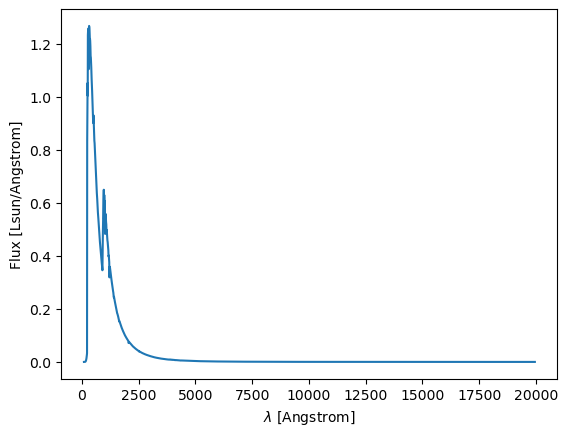

In [19]:
# NBVAL_SKIP
plt.plot(ssp.wavelength,ssp.flux[0][0])
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")

Text(0, 0.5, 'Flux [Lsun/Angstrom]')

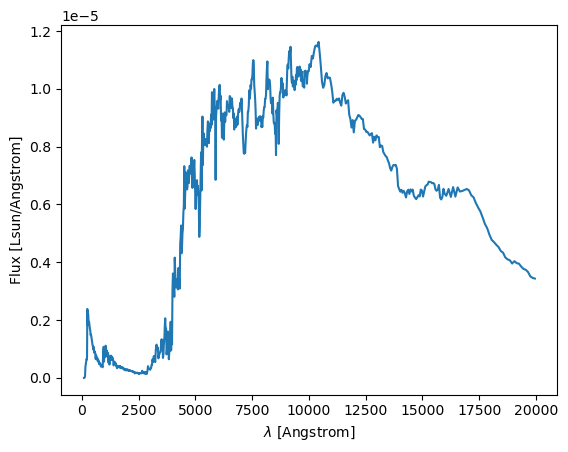

In [20]:
# NBVAL_SKIP
plt.plot(ssp.wavelength,ssp.flux[-1][-1])
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")

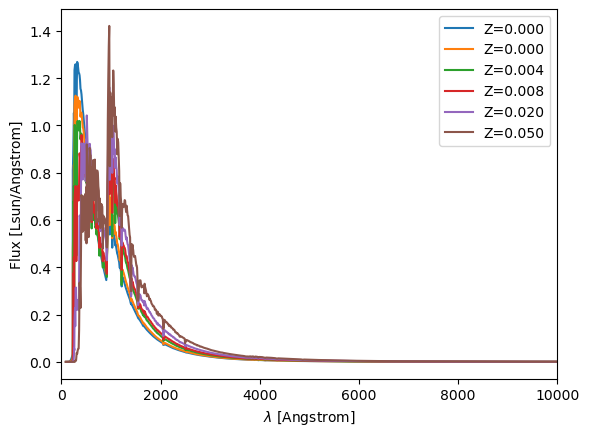

In [21]:
# NBVAL_SKIP
for i in range(len(ssp.metallicity)):
    plt.plot(ssp.wavelength,ssp.flux[i][0], label=r'Z=%0.3f'%ssp.metallicity[i])
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")
plt.xlim(0,10000)
plt.legend()

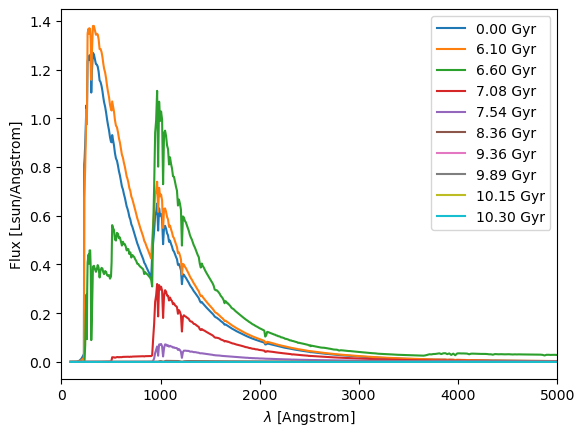

In [22]:
# NBVAL_SKIP
ages = np.linspace(0,len(ssp.age),10)
for age in ages:
    plt.plot(ssp.wavelength,ssp.flux[0][int(age)], label='%.2f %s'%(ssp.age[int(age)], config["fields"]["age"]["units"]))
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")
plt.xlim(0,5000)
plt.legend()

# Automatic download supported SSP template
Rubix supports automatic download of a supported SSP template from a specified url in case the template can't be found on disk under the file_location specified.

In [23]:
# NBVAL_SKIP
config = {
        "name": "Mastar Charlot & Bruzual (2019)",
        "format": "pyPipe3D",
        "source": "https://ifs.astroscu.unam.mx/pyPipe3D/templates/",
        "file_name": "MaStar_CB19.slog_1_5.fits.gz",
        "fields": {
            "age": {
                "name": "age",
                "units": "Gyr",
                "in_log": False
            },
            "metallicity": {
                "name": "metallicity",
                "units": "",
                "in_log": False
            },
            "wavelength": {
                "name": "wavelength",
                "units": "Angstrom",
                "in_log": False
            },
            "flux": {
                "name": "flux",
                "units": "Lsun/Angstrom",
                "in_log": False
            }
        }
    }

In [24]:
# NBVAL_SKIP
from rubix.spectra.ssp.grid import pyPipe3DSSPGrid
ssp = pyPipe3DSSPGrid.from_file(config, file_location="../rubix/spectra/ssp/templates")
ssp

pyPipe3DSSPGrid(age=Array([1.000e-03, 2.300e-03, 3.800e-03, 5.750e-03, 8.000e-03, 1.150e-02,
       1.500e-02, 2.000e-02, 2.600e-02, 3.300e-02, 4.250e-02, 5.350e-02,
       7.000e-02, 9.000e-02, 1.100e-01, 1.400e-01, 1.800e-01, 2.250e-01,
       2.750e-01, 3.500e-01, 4.500e-01, 5.500e-01, 6.500e-01, 8.500e-01,
       1.100e+00, 1.300e+00, 1.600e+00, 2.000e+00, 2.500e+00, 3.000e+00,
       3.750e+00, 4.500e+00, 5.250e+00, 6.250e+00, 7.500e+00, 8.500e+00,
       1.025e+01, 1.200e+01, 1.350e+01], dtype=float32), metallicity=Array([0.0001, 0.0005, 0.002 , 0.008 , 0.017 , 0.03  , 0.04  ], dtype=float32), wavelength=Array([2000. , 2001.5, 2003. , ..., 9995. , 9996.5, 9998. ], dtype=float32), flux=Array([[[4.88501154e-02, 4.91619967e-02, 4.91009988e-02, ...,
         3.30204784e-04, 3.29886097e-04, 3.29610863e-04],
        [4.94970530e-02, 5.01737520e-02, 5.02070002e-02, ...,
         4.14328271e-04, 4.13853064e-04, 4.13406960e-04],
        [8.76932293e-02, 8.82892460e-02, 8.89149979e-02, ...

In [25]:
# NBVAL_SKIP
ssp.age.shape

(39,)

In [26]:
# NBVAL_SKIP
ssp.metallicity.shape

(7,)

In [27]:
# NBVAL_SKIP
ssp.wavelength.shape

(5333,)

In [28]:
# NBVAL_SKIP
ssp.flux.shape

(7, 39, 5333)

# Lets plot some example spectra
Example for Mastar templates

In [29]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Flux [Lsun/Angstrom]')

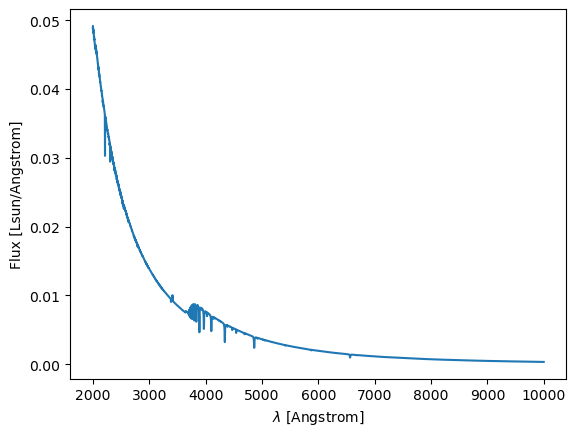

In [30]:
# NBVAL_SKIP
plt.plot(ssp.wavelength,ssp.flux[0][0])
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")

Text(0, 0.5, 'Flux [Lsun/Angstrom]')

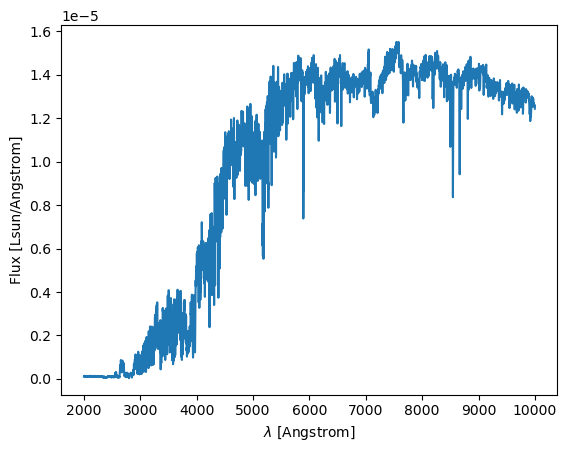

In [31]:
# NBVAL_SKIP
plt.plot(ssp.wavelength,ssp.flux[-1][-1])
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")

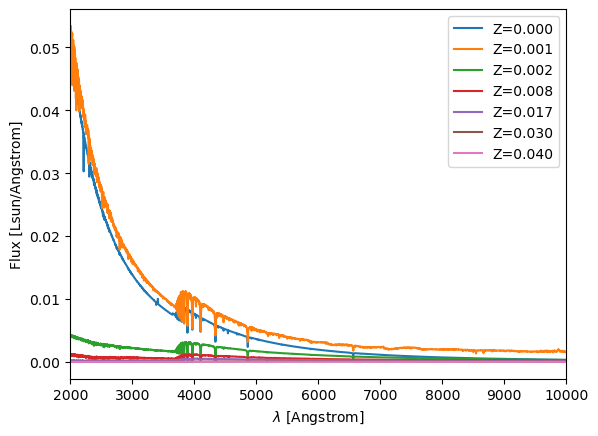

In [32]:
# NBVAL_SKIP
for i in range(len(ssp.metallicity)):
    plt.plot(ssp.wavelength,ssp.flux[i][0], label=r'Z=%0.3f'%ssp.metallicity[i])
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")
plt.xlim(2000,10000)
plt.legend()

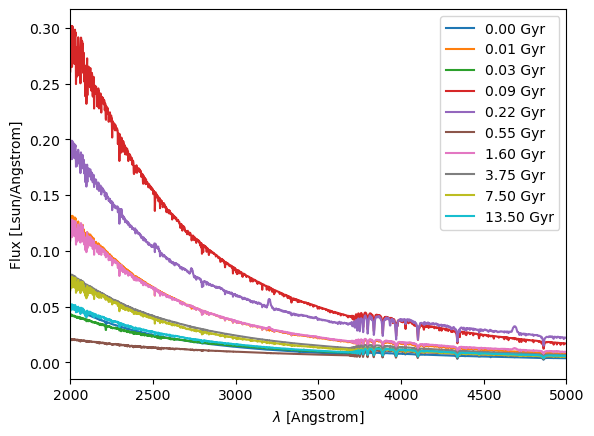

In [33]:
# NBVAL_SKIP
ages = np.linspace(0,len(ssp.age),10)
for age in ages:
    plt.plot(ssp.wavelength,ssp.flux[0][int(age)], label='%.2f %s'%(ssp.age[int(age)], config["fields"]["age"]["units"]))
plt.xlabel(r'$\lambda$ [%s]'%config["fields"]["wavelength"]["units"])
plt.ylabel(r'Flux [%s]'%config["fields"]["flux"]["units"])
#plt.yscale("log")
plt.xlim(2000,5000)
plt.legend()